## Lab assignment 02

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the RU-EN translation task.

Basic approach using RNNs as encoder and decoder is implemented for you.

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* Transformer/CNN/<whatever you select> encoder (with or without positional encoding)

* attention/self-attention mechanism (**highly recommended**)

* custom tokenization (BPE units, other subword approaches)

to improve the translation quality.

--------

* __Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

* Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [ ]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

# ! pip  install subword-nmt
# ! pip install nltk
# ! pip install torchtext

In [1]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github.
File ‘data.txt’ already there; not retrieving.



#### Grading criteria

**100%**
- implementation of at least 3 model improvements over baseline
- threshold of 27 BLEU on test corpus
- experimental results and conclusions in human-readable format :)

**70%**
- implementation of at least 2 model improvements over baseline
- threshold of 25 BLEU on test corpus
- experimental results and conclusions in human-readable format :)

**30%**
- implementation of at least 1 model improvement over baseline
- threshold of 21 BLEU on test corpus
- experimental results and conclusions in human-readable format :)


------

#### **Note: Please do not use pretrained machine translation / BERT / LLM checkpoints. All such solutions will be graded at 30% pts.**


### Warning! The code below is deeeeeeeply deprecated and is is provided only as simple guide.
We suggest you to stick to most recent pipelines here, e.g. by Huggingface:
* Example notebook: [link](https://github.com/huggingface/notebooks/blob/main/examples/translation.ipynb)
* Converting your own dataset to specific format: [link](https://discuss.huggingface.co/t/correct-way-to-create-a-dataset-from-a-csv-file/15686/15)

In [2]:
# old deprecated code
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE


### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [3]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [4]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

dataset = torchtext.data.TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [5]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [6]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [7]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [8]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9279
Unique tokens in target (en) vocabulary: 6680


Here are tokens from original (RU) corpus:

In [9]:
SRC.vocab.itos[::1000]

['<unk>',
 'sea',
 'велосипедную',
 'кафельный',
 '280',
 'хранение',
 'jardins',
 'трибхуван',
 'диско',
 'сукарно']

And from target (EN) corpus:

In [10]:
TRG.vocab.itos[::1000]

['<unk>',
 'guangzhou',
 'egyptian',
 'choices',
 'navy',
 'southwest',
 'mecklenburg']

And here is example from train dataset:

In [11]:
print(vars(train_data.examples[9]))

{'trg': ['the', 'nearest', 'grocery', 'store', 'is', '500', 'metres', 'away', 'and', 'a', 'restaurant', 'is', '300', 'metres', 'further', '.'], 'src': ['ближайший', 'продуктовый', 'магазин', 'находится', 'в', '500', 'метрах', ',', 'а', 'ресторан', '—', 'на', '300', 'метров', 'дальше', '.']}


Let's check the length distributions:

Length distribution in Train data


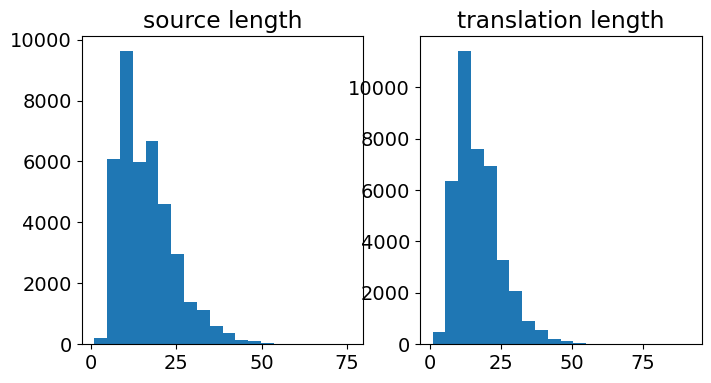

In [12]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


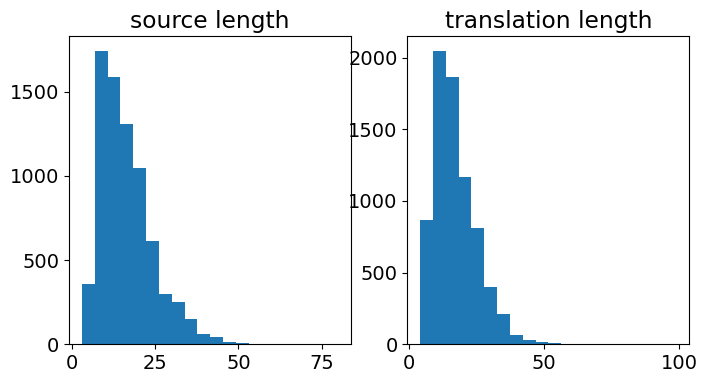

In [13]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week02 practice__

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device,
    sort_key=_len_sort_key)

for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)

cuda

[torchtext.data.batch.Batch of size 16]
	[.trg]:[torch.cuda.LongTensor of size 50x16 (GPU 0)]
	[.src]:[torch.cuda.LongTensor of size 39x16 (GPU 0)]
torch.Size([39, 16]) torch.Size([50, 16])


Here my improvements of code

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import random
import math
import time

In [16]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [17]:
class Encoder(nn.Module):
    def create_node(self, dropout):
        return nn.ModuleDict({
            'SelfAttention' : nn.MultiheadAttention(embed_dim=self.emb_dim, num_heads=2, dropout=dropout),
            'LayerNorm_1'   : nn.LayerNorm(self.emb_dim),
            'FeedForward'   : nn.Linear(in_features=self.emb_dim, out_features=self.emb_dim),
            'LayerNorm_2'   : nn.LayerNorm(self.emb_dim)})

    def __init__(self, emb_dim, n_layers, dropout, k_size, input_dim, max_seg_legth=128):
        super().__init__()

        self.emb_dim = emb_dim
        self.k_size  = k_size
        self.n_layers = n_layers
        self.num_heads = 1
        
        self.embedding = nn.Embedding(num_embeddings=input_dim, embedding_dim=emb_dim)
        self.positional_encoding = PositionalEncoding(emb_dim, max_seg_legth)
        self.dropout = nn.Dropout(p=dropout)
        self.nodes = nn.ModuleList([self.create_node(dropout) for _ in range (self.n_layers)])
        self.norm = nn.LayerNorm(emb_dim)

    def forward(self, src):
        inp = self.dropout(self.positional_encoding(self.embedding(src)))
        for node in self.nodes:
            t, _  = node['SelfAttention'](inp, inp, inp)
            t     = node['LayerNorm_1'](torch.add(t, inp))
            inp = node['LayerNorm_2'](node['FeedForward'](t))

        return inp

In [18]:
class Decoder(nn.Module):
    def create_node(self, dropout):
        return nn.ModuleDict({
            'SelfAttention'  : nn.MultiheadAttention(embed_dim=self.emb_dim, num_heads=2, dropout=dropout),
            'LayerNorm_1'    : nn.LayerNorm(self.emb_dim),
            'CrossAttention' : nn.MultiheadAttention(embed_dim=self.emb_dim, num_heads=2, dropout=dropout),
            'LayerNorm_2'    : nn.LayerNorm(self.emb_dim),
            'FeedForward'    : nn.Linear(in_features=self.emb_dim, out_features=self.emb_dim),
            'LayerNorm_3'    : nn.LayerNorm(self.emb_dim)})

    def __init__(self, output_dim, emb_dim, n_layers, k_size, dropout, max_seg_legth=128):
        super().__init__()

        self.emb_dim = emb_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.k_size = k_size
        self.num_heads = 1

        self.embedding = nn.Embedding(num_embeddings=output_dim,embedding_dim=emb_dim)
        self.positional_encoding = PositionalEncoding(emb_dim, max_seg_legth)
        self.dropout = nn.Dropout(p=dropout)
        self.nodes = nn.ModuleList([self.create_node(dropout) for _ in range(self.n_layers)])
        self.out = nn.Linear(in_features=emb_dim, out_features=output_dim)

    def forward(self, inp, encode_inp):
        inp = self.dropout(self.positional_encoding(self.embedding(inp.unsqueeze(0))))

        for node in self.nodes : 
            t, _ = node['SelfAttention'](inp, inp, inp)
            t = node['LayerNorm_1'](torch.add(t, inp))
            
            output, _ = node['CrossAttention'](query=t, key=encode_inp, value=encode_inp)
            output = node['LayerNorm_2'](torch.add(t, output))
            
            inp = node['FeedForward'](output)
            inp = node['LayerNorm_3'](torch.add(output, inp))

        output = self.out(inp.squeeze(0))
        return output


In [19]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder, device, input_dim, output_dim, emb_dim_enc, emb_dim_dec):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.output_dim = output_dim
        self.input_dim = input_dim
        self.emb_dim_enc = emb_dim_enc
        self.emb_dim_dec = emb_dim_dec
        
        # assert encoder.hid_dim == decoder.hid_dim, \
        #     "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        batch_size = trg.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)

        enc_output = self.encoder(src)
        inp = trg[0, :]

        for t in range(1, max_len):
            output = self.decoder(inp, enc_output)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            inp = (trg[t] if teacher_force else top1)
        
        return outputs

So now let's test it!

In [20]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM, DEC_EMB_DIM = 256, 256
ENC_DROPOUT, DEC_DROPOUT = 0.5, 0.5
ENC_KERNEL_SIZE, DEC_KERNEL_SIZE = 3, 3
N_LAYERS = 3

enc = Encoder(emb_dim=ENC_EMB_DIM, n_layers=N_LAYERS, dropout=ENC_DROPOUT, k_size=ENC_KERNEL_SIZE, input_dim=INPUT_DIM)
dec = Decoder(output_dim=OUTPUT_DIM, emb_dim=DEC_EMB_DIM, n_layers=N_LAYERS, dropout=DEC_DROPOUT, k_size=DEC_KERNEL_SIZE)

# dont forget to put the model to the right device
model = Transformer(enc, dec, device, INPUT_DIM, OUTPUT_DIM, ENC_EMB_DIM, DEC_EMB_DIM).to(device)

In [21]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)

model.apply(init_weights)

Transformer(
  (encoder): Encoder(
    (embedding): Embedding(9279, 512)
    (positional_encoding): PositionalEncoding()
    (dropout): Dropout(p=0.5, inplace=False)
    (nodes): ModuleList(
      (0-5): 6 x ModuleDict(
        (SelfAttention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (LayerNorm_1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (FeedForward): Linear(in_features=512, out_features=512, bias=True)
        (LayerNorm_2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      )
    )
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(6680, 512)
    (positional_encoding): PositionalEncoding()
    (dropout): Dropout(p=0.5, inplace=False)
    (nodes): ModuleList(
      (0-5): 6 x ModuleDict(
        (SelfAttention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_fe

In [22]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 33,692,696 trainable parameters


In [23]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [24]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()

    epoch_loss = 0

    history = []
    for i, batch in enumerate(iterator):
        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()
        output = model(src, trg)

        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)

        loss = criterion(output, trg)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()

            plt.show()

    return epoch_loss / len(iterator)

In [25]:
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    history = []

    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0)
            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)

            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

In [26]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [27]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

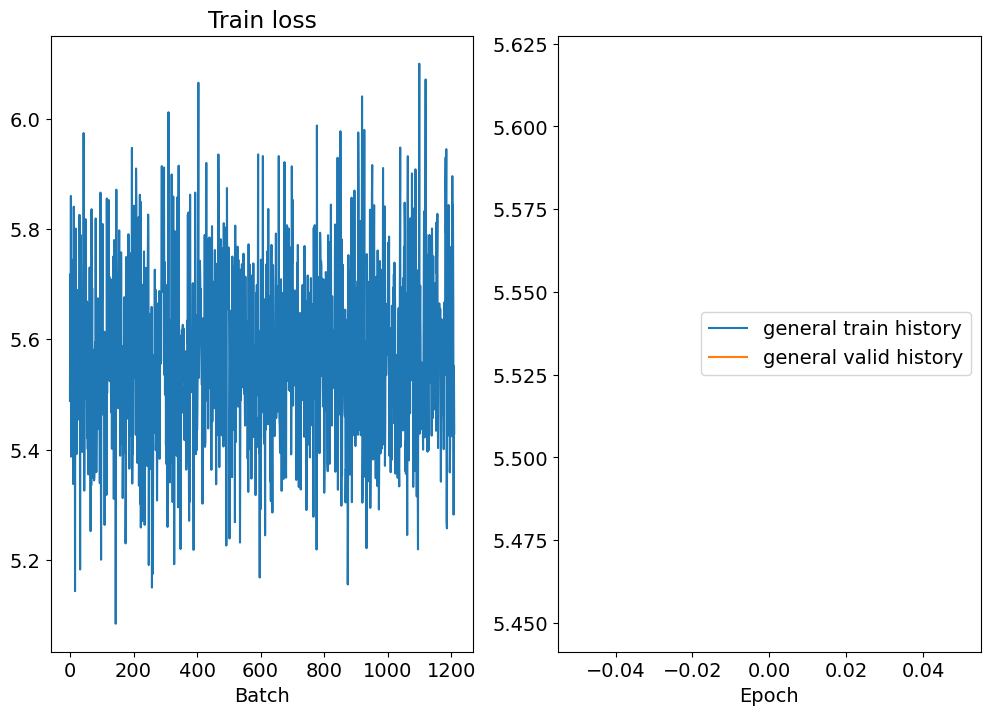

KeyboardInterrupt: 

In [28]:
for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

__Let's take a look at our network quality__:

In [29]:
def flatten(l):
    return [item for sublist in l for item in sublist]

def remove_tech_tokens(mystr, tokens_to_remove=['<eos>', '<sos>', '<unk>', '<pad>']):
    return [x for x in mystr if x not in tokens_to_remove]


def get_text(x, TRG_vocab):
    text = [TRG_vocab.itos[token] for token in x]
    try:
        end_idx = text.index('<eos>')
        text = text[:end_idx]
    except ValueError:
        pass
    text = remove_tech_tokens(text)
    if len(text) < 1:
        text = []
    return text


def generate_translation(src, trg, model, TRG_vocab):
    model.eval()

    output = model(src, trg, 0) #turn off teacher forcing
    output = output.argmax(dim=-1).cpu().numpy()

    original = get_text(list(trg[:,0].cpu().numpy()), TRG_vocab)
    generated = get_text(list(output[1:, 0]), TRG_vocab)
    
    print('Original: {}'.format(' '.join(original)))
    print('Generated: {}'.format(' '.join(generated)))
    print()


In [30]:
batch = next(iter(test_iterator))

In [31]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: there is a 24 - hour front desk at the property .
Generated: a 24 - hour front desk and a 24 - hour front desk

Original: guests can enjoy the on - site bar .
Generated: the .



In [32]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [34]:
import tqdm

In [35]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)

        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

print(len(original_text))
print(len(generated_text))

235it [00:06, 37.22it/s]

7500
7500


In [36]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

2.76859495626367